## Encoding of sd-shell $H_Q$ for quantum annealing

In [78]:
import qiskit
import numpy as np
from qiskit.quantum_info import SparsePauliOp

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from typing import Dict


In [2]:
data_onebody=np.load('data/matrix_elements_h_eff_2body/one_body_nn_sd.npz')
keys=data_onebody['keys']
values=data_onebody['values']
n_qubits=6

t_onebody={}

for a,key in enumerate(keys):
    i,j=key
    t_onebody[(i,j)]=values[a]

# print(t_onebody)
# t_onebody.pop((0,1))
# t_onebody.pop((0,2))
# t_onebody.pop((1,2))

print(t_onebody)

{(np.int64(0), np.int64(0)): np.float64(-9.3151), (np.int64(0), np.int64(1)): np.float64(0.6897999999999996), (np.int64(0), np.int64(2)): np.float64(-0.4062999999999996), (np.int64(0), np.int64(3)): np.float64(-0.900781889989654), (np.int64(0), np.int64(4)): np.float64(-1.9314456782406446), (np.int64(0), np.int64(5)): np.float64(0.6017349640876247), (np.int64(1), np.int64(0)): np.float64(0.6897999999999996), (np.int64(1), np.int64(1)): np.float64(-8.8615), (np.int64(1), np.int64(2)): np.float64(0.8598999999999998), (np.int64(1), np.int64(3)): np.float64(0.900781889989654), (np.int64(1), np.int64(4)): np.float64(1.1336192497488327), (np.int64(1), np.int64(5)): np.float64(-1.3995613925794368), (np.int64(2), np.int64(0)): np.float64(-0.4062999999999996), (np.int64(2), np.int64(1)): np.float64(0.8598999999999998), (np.int64(2), np.int64(2)): np.float64(-9.145), (np.int64(2), np.int64(3)): np.float64(-0.900781889989654), (np.int64(2), np.int64(4)): np.float64(-0.7347060355029268), (np.int64

In [27]:
data_twobody=np.load('data/matrix_elements_h_eff_2body/twobody_nn_sd.npz')
keys=data_twobody['keys']
values=data_twobody['values']
n_qubits=6

t_twobody={}

for a,key in enumerate(keys):
    i,j,l,m=key
    t_twobody[(i,j,l,m)]=values[a]
    
# print(t_twobody)
# t_twobody.pop((0,1))
# t_twobody.pop((0,2))
# t_twobody.pop((1,2))

print(t_twobody.keys())

dict_keys([(np.int64(0), np.int64(1), np.int64(0), np.int64(1)), (np.int64(0), np.int64(2), np.int64(0), np.int64(2)), (np.int64(0), np.int64(3), np.int64(0), np.int64(3)), (np.int64(0), np.int64(4), np.int64(0), np.int64(4)), (np.int64(0), np.int64(5), np.int64(0), np.int64(5)), (np.int64(1), np.int64(2), np.int64(1), np.int64(2)), (np.int64(1), np.int64(3), np.int64(1), np.int64(3)), (np.int64(1), np.int64(4), np.int64(1), np.int64(4)), (np.int64(1), np.int64(5), np.int64(1), np.int64(5)), (np.int64(2), np.int64(3), np.int64(2), np.int64(3)), (np.int64(2), np.int64(4), np.int64(2), np.int64(4)), (np.int64(2), np.int64(5), np.int64(2), np.int64(5)), (np.int64(3), np.int64(4), np.int64(3), np.int64(4)), (np.int64(3), np.int64(5), np.int64(3), np.int64(5)), (np.int64(4), np.int64(5), np.int64(4), np.int64(5))])


In [118]:
def get_hamiltonian(t_onebody:Dict, n_sites:int, t_twobody:Dict=None,include_ladder_terms=False) -> SparsePauliOp:

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    XX_tuples=[]
    YY_tuples=[]
    Z_tuples=[]
    I_tuples=[]
    for (i,j),t_val in t_onebody.items():
    
        if i==j:
            Z_tuples.append(("Z", [i], -0.5*t_val))
            I_tuples.append(('I',[i],0.5*t_val)) 
        else:
            XX_tuples.append( ("XX", [i, j], 0.25*t_val) )
            YY_tuples.append(("YY", [i, j], 0.25*t_val) )
            
    if include_ladder_terms:
        ladder_terms = []
        for (i,j,l,m),t_val in t_twobody.items():
            print(t_val)
            if (i==l and j==m) or (i==m and j==l):
                ladder_terms.append(
                ("II", [i, j], (1/4) * t_val))
                ladder_terms.append(
                ("IZ", [i, j], -(1/4)* t_val))
                ladder_terms.append(
                ("ZI", [i, j], -(1/4) * t_val))
                ladder_terms.append(
                ("ZZ", [i, j], (1/4) * t_val))
                
    #print(csr_matrix(SparsePauliOp.from_sparse_list([*ladder_terms],num_qubits=n_sites).to_matrix()))
    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples,*Z_tuples,*I_tuples,*ladder_terms], num_qubits=n_sites)
    return hamiltonian.simplify()


In [119]:
hamiltonian_q=get_hamiltonian(t_onebody=t_onebody,n_sites=n_qubits,include_ladder_terms=True,t_twobody=t_twobody)


-1.9616000000000007
-1.394600000000004
0.02873333333332795
-2.203928571428574
0.058295238095237956
-2.3017999999999965
0.0287333333333315
-0.8465942857142865
-1.2990390476190479
0.028733333333335054
-0.16792714285714272
-1.9777061904761917
0.015199999999999214
0.015199999999999214
-0.3896000000000015


In [120]:
from itertools import combinations

def generate_fixed_weight_bitstrings(n_qubits, num_ones):
    bitstrings = []
    for ones_pos in combinations(range(n_qubits), num_ones):
        bitstring = np.zeros(n_qubits, dtype=float)  # float if you want to match matrix dtype
        bitstring[list(ones_pos)] = 1.
        bitstrings.append(bitstring)
    return np.array(bitstrings)


n_qubits = 6
num_ones = 2

bitstrings_array = generate_fixed_weight_bitstrings(n_qubits, num_ones)
print(bitstrings_array)  # should be (15, 12)


[[1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1.]]


In [127]:
from scipy.sparse import csr_matrix

for idx_b,b in enumerate(bitstrings_array):
    for idx_d,d in enumerate(bitstrings_array):
        i,j=np.nonzero(b)[0]
        l,m=np.nonzero(d)[0]
        if idx_d==0:
            print(d)
        print(f'{idx_b} -> {idx_d} -> {csr_matrix(hamiltonian_q.to_matrix())[2**(i)+2**j,2**l+2**m]}')


[1. 1. 0. 0. 0. 0.]
0 -> 0 -> (-20.13820000000001+0j)
0 -> 1 -> (0.8598999999999998+0j)
0 -> 2 -> (0.900781889989654+0j)
0 -> 3 -> (1.1336192497488327+0j)
0 -> 4 -> (-1.3995613925794368+0j)
0 -> 5 -> (-0.4062999999999996+0j)
0 -> 6 -> (-0.900781889989654+0j)
0 -> 7 -> (-1.9314456782406446+0j)
0 -> 8 -> (0.6017349640876247+0j)
0 -> 9 -> 0j
0 -> 10 -> 0j
0 -> 11 -> 0j
0 -> 12 -> 0j
0 -> 13 -> 0j
0 -> 14 -> 0j
[1. 1. 0. 0. 0. 0.]
1 -> 0 -> (0.8598999999999998+0j)
1 -> 1 -> (-19.854700000000005+0j)
1 -> 2 -> (-0.900781889989654+0j)
1 -> 3 -> (-0.7347060355029268+0j)
1 -> 4 -> (1.7984746068253425+0j)
1 -> 5 -> (0.6897999999999996+0j)
1 -> 6 -> 0j
1 -> 7 -> 0j
1 -> 8 -> 0j
1 -> 9 -> (-0.900781889989654+0j)
1 -> 10 -> (-1.9314456782406446+0j)
1 -> 11 -> (0.6017349640876247+0j)
1 -> 12 -> 0j
1 -> 13 -> 0j
1 -> 14 -> 0j
[1. 1. 0. 0. 0. 0.]
2 -> 0 -> (0.900781889989654+0j)
2 -> 1 -> (-0.900781889989654+0j)
2 -> 2 -> (-17.39346666666668+0j)
2 -> 3 -> (-0.7177133829043456+0j)
2 -> 4 -> (0.71771338

In [132]:
coupling_term=-20.1382
Z_tuples=[("Z", [0], -0.5*coupling_term),("Z", [1], -0.5*coupling_term)]
I_tuples=[('I',[0],0.5*coupling_term),("I", [1], -0.5*coupling_term)]

        
# We create the Hamiltonian as a SparsePauliOp, via the method
# `from_sparse_list`, and multiply by the interaction term.
hamiltonian_driver = SparsePauliOp.from_sparse_list([*Z_tuples,*I_tuples], num_qubits=n_qubits)
print(hamiltonian_driver)

print(csr_matrix(hamiltonian_driver.to_matrix()))

SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIIII', 'IIIIII'],
              coeffs=[ 10.0691+0.j,  10.0691+0.j, -10.0691+0.j,  10.0691+0.j])
<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 32 stored elements and shape (64, 64)>
  Coords	Values
  (0, 0)	(20.1382+0j)
  (3, 3)	(-20.1382+0j)
  (4, 4)	(20.1382+0j)
  (7, 7)	(-20.1382+0j)
  (8, 8)	(20.1382+0j)
  (11, 11)	(-20.1382+0j)
  (12, 12)	(20.1382+0j)
  (15, 15)	(-20.1382+0j)
  (16, 16)	(20.1382+0j)
  (19, 19)	(-20.1382+0j)
  (20, 20)	(20.1382+0j)
  (23, 23)	(-20.1382+0j)
  (24, 24)	(20.1382+0j)
  (27, 27)	(-20.1382+0j)
  (28, 28)	(20.1382+0j)
  (31, 31)	(-20.1382+0j)
  (32, 32)	(20.1382+0j)
  (35, 35)	(-20.1382+0j)
  (36, 36)	(20.1382+0j)
  (39, 39)	(-20.1382+0j)
  (40, 40)	(20.1382+0j)
  (43, 43)	(-20.1382+0j)
  (44, 44)	(20.1382+0j)
  (47, 47)	(-20.1382+0j)
  (48, 48)	(20.1382+0j)
  (51, 51)	(-20.1382+0j)
  (52, 52)	(20.1382+0j)
  (55, 55)	(-20.1382+0j)
  (56, 56)	(20.1382+0j)
  (59, 59)	(-20.1382+0j)
  (60, 60)	(20.1382+

In [187]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter,QDrift,LieTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Operator
from tqdm import trange
#final_state=Statevector(circuit_opt)
time_steps=130
tf=13
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
print(dt)
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
driver=1-time/tf
circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits)
circuit_time_evolution.x([0]) # initial state
circuit_time_evolution.x([1])
energies_qiskit=np.zeros((time_steps))


for n,t in enumerate(time):
    hamiltonian_t=(driver[n])*hamiltonian_driver+(1-driver[n])*hamiltonian_q
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=2))
    #exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=QDrift(reps=5))
    circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
    single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
    psi_for_fidelity=np.zeros(bitstrings_array.shape[0],dtype=np.complex128)

    energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t).real

transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])
#

0.1


In [188]:
print(energies_qiskit[-1])

0.0


In [189]:
final_state=Statevector(circuit_time_evolution)
for idx_b,b in enumerate(bitstrings_array):
    i,j=np.nonzero(b)[0]
    single_particle_vector[2**i + 2**j]=final_state.data[2**i + 2**j]
    psi_for_fidelity[idx_b]=final_state.data[2**i + 2**j ]

psi_for_fidelity=psi_for_fidelity/np.linalg.norm(psi_for_fidelity)  

print(final_state.expectation_value(hamiltonian_q).real)

-23.364472085869235


In [183]:
transpiled_circuit_time_evolution.draw()
from qiskit.visualization import circuit_drawer
circuit_drawer(transpiled_circuit_time_evolution, output='mpl', filename='qiskit_circuit.pdf', fold=-1)

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

In [190]:

print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {transpiled_circuit_time_evolution.depth()}
             Gate count: {len(transpiled_circuit_time_evolution)}
    Nonlocal gate count: {transpiled_circuit_time_evolution.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in transpiled_circuit_time_evolution.count_ops().items()])}

"""
)



# And finall
%matplotlib inline
#initial_state.draw("text")


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 20660
             Gate count: 49689
    Nonlocal gate count: 22706
         Gate breakdown: CX: 22706, RZ: 19495, H: 6714, S: 774




In [192]:
titles_q=[r'${20}^$O',]
cnot_q_hamiltonian=[22706,]

## Encoding of sd shell $H$ for quantum annealing

Imports

In [193]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np

from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp,HardcoreBosonsBasis
from scipy.sparse import lil_matrix


file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)



nparts=[(4,0)]
titles=[r'$^{18}$O']



size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{18}$O'

Two-body matrix

In [3]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:50<00:00,  2.09s/it]


Nuclear Shell Model Hamiltonian

In [194]:
from scipy.sparse import identity
#Quadrupole Operator
energy_errors=[]
fidelities=[]
for idx,npart in enumerate(nparts):
    nparticles_a,nparticles_b=npart
    title=titles[idx]
    
    # compute the NSM Hamiltonian
    NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
    print('size=',size_a+size_b,size_b)
    NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
    if file_name=='data/cki':
        twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

        NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
    else:
        NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
    NSMHamiltonian.get_hamiltonian()

    
    shifted_hamiltonian=NSMHamiltonian.hamiltonian


    egs,psi0=eigsh(shifted_hamiltonian,k=1,which='SA')

    print('ground state energy=',egs[0])

size= 24 12
ground state energy= -23.93429270827927


In [195]:
from src.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp,HardcoreBosonsBasis
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)

hamiltonian_qq=QPC.particles2quasiparticles @ shifted_hamiltonian @ QPC.particles2quasiparticles.T

egs_qq,psi_q=eigsh(hamiltonian_qq,k=1,which='SA')
psi_for_fidelity=psi_for_fidelity/np.linalg.norm(psi_for_fidelity)
print(egs_qq)
print(psi_for_fidelity.shape)
print(psi_q[:,0].conjugate().dot(psi_for_fidelity)*(psi_q[:,0].conjugate().dot(psi_for_fidelity)).conjugate())


[-23.42493918]
(15,)
(0.9876282914850177+0j)


In [196]:
0.99*0.95

0.9405

In [139]:
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper,BravyiKitaevMapper

# Start building terms
hamiltonian_terms = {}
n_spin_orbitals =  size_a  # Assuming spin-orbitals are double the single-particle states
# One-body terms: e_a * c†_a c_a
for a, e_a in enumerate(SPS.energies[:size_a]):
    label = f"+_{a} -_{a}"
    hamiltonian_terms[label] = hamiltonian_terms.get(label, 0) + e_a

# Two-body terms: (1/4) * v_abcd * c†_a c†_b c_d c_c
for (a, b, c, d), v_abcd in twobody_matrix.items():
    if a<size_a and b<size_a and c<size_a and d<size_a:
        label = f"+_{a} +_{b} -_{d} -_{c}"
        coef = 0.25 * v_abcd
        hamiltonian_terms[label] = hamiltonian_terms.get(label, 0) + coef

# Create FermionicOp
nsm_hamiltoninan_fermions = FermionicOp(hamiltonian_terms, num_spin_orbitals=n_spin_orbitals)

# (Optional) Print to inspect
print(nsm_hamiltoninan_fermions)

ModuleNotFoundError: No module named 'qiskit_nature'

In [6]:
mapper = JordanWignerMapper()
nsm_hamiltonian_qubit = mapper.map(nsm_hamiltoninan_fermions)

In [7]:
print(NSMHamiltonian.hamiltonian)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 180 stored elements and shape (14, 14)>
  Coords	Values
  (0, 0)	-9.3151
  (0, 1)	0.6897999999999996
  (0, 2)	0.20328479938540372
  (0, 3)	-0.4062999999999996
  (0, 4)	-0.5082840208321855
  (0, 5)	0.18949464964372487
  (0, 6)	0.5082840208321854
  (0, 7)	0.18949464964372495
  (0, 8)	0.20328479938540372
  (0, 9)	-0.900781889989654
  (0, 10)	0.48367995370807726
  (0, 11)	0.48367995370807726
  (0, 12)	-1.9314456782406446
  (0, 13)	0.6017349640876247
  (1, 0)	0.6897999999999996
  (1, 1)	-8.8615
  (1, 2)	0.30763695987708084
  (1, 3)	0.8598999999999998
  (1, 4)	-0.10165680416643715
  (1, 5)	0.6918637014569979
  (1, 6)	0.10165680416643713
  (1, 7)	0.691863701456998
  (1, 8)	0.30763695987708073
  (1, 9)	0.900781889989654
  (1, 10)	0.09673599074161551
  :	:
  (12, 3)	-0.7347060355029268
  (12, 4)	-0.15865000000000007
  (12, 5)	-0.09509586140912163
  (12, 6)	0.15865000000000004
  (12, 7)	-0.09509586140912159
  (12, 8)	0.232936337102774

In [8]:

from scipy.sparse import csr_matrix
n_qubits = nsm_hamiltonian_qubit.num_qubits

for idx_b,b in enumerate(NSMHamiltonian.basis):
    for idx_d,d in enumerate(NSMHamiltonian.basis):
        b_1,b_2=np.nonzero(b)[0]
        d_1,d_2=np.nonzero(d)[0]

        print(f'i={(idx_b)},j={(idx_d)} ->{csr_matrix(nsm_hamiltonian_qubit.to_matrix())[2**(b_1)+2**(b_2),2**(d_1)+2**(d_2)]-NSMHamiltonian.hamiltonian[idx_b,idx_d]} \n')


i=0,j=0 ->(8.881784197001252e-15+0j) 

i=0,j=1 ->(2.220446049250313e-16+0j) 

i=0,j=2 ->(-2.7755575615628914e-17+0j) 

i=0,j=3 ->(1.1102230246251565e-16+0j) 

i=0,j=4 ->0j 

i=0,j=5 ->0j 

i=0,j=6 ->0j 

i=0,j=7 ->(-5.551115123125783e-17+0j) 

i=0,j=8 ->(-2.7755575615628914e-17+0j) 

i=0,j=9 ->(1.1102230246251565e-16+0j) 

i=0,j=10 ->(5.551115123125783e-17+0j) 

i=0,j=11 ->(5.551115123125783e-17+0j) 

i=0,j=12 ->(2.220446049250313e-16+0j) 

i=0,j=13 ->0j 

i=1,j=0 ->(2.220446049250313e-16+0j) 

i=1,j=1 ->(7.105427357601002e-15+0j) 

i=1,j=2 ->(-1.6653345369377348e-16+0j) 

i=1,j=3 ->0j 

i=1,j=4 ->(-2.7755575615628914e-17+0j) 

i=1,j=5 ->0j 

i=1,j=6 ->(4.163336342344337e-17+0j) 

i=1,j=7 ->0j 

i=1,j=8 ->0j 

i=1,j=9 ->(-1.1102230246251565e-16+0j) 

i=1,j=10 ->(1.3877787807814457e-17+0j) 

i=1,j=11 ->(1.3877787807814457e-17+0j) 

i=1,j=12 ->0j 

i=1,j=13 ->0j 

i=2,j=0 ->(-2.7755575615628914e-17+0j) 

i=2,j=1 ->(-1.6653345369377348e-16+0j) 

i=2,j=2 ->(2.6645352591003757e-15+0j) 

i=2

Driver Hamiltonian

In [17]:
#### Initial Hamiltonian
min_b=np.zeros(size_a+size_b)

if file_name=='data/cki':
    order_of_filling=np.asarray([0,3,1,2,4,5])
    order_of_filling_protons=order_of_filling+size_a
else:
    order_of_filling=np.asarray([0,5,1,4,2,3,6,7,8,11,9,10])
    order_of_filling_protons=order_of_filling+size_a


min_b[order_of_filling[:nparticles_a]]=1
min_b[order_of_filling_protons[:nparticles_b]]=1

print(min_b)

print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(NSMHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

print('external field=',external_field)

e0,psis=InitialHamiltonian.get_spectrum(n_states=1)
psi_configuration=psis[:,0]



[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
initial state= [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
idx= 0
min energy= -9.3151
external field= [-4.65755 -0.      -0.      -0.      -0.      -4.65755 -0.      -0.
 -0.      -0.      -0.      -0.      -0.      -0.      -0.      -0.
 -0.      -0.      -0.      -0.      -0.      -0.      -0.      -0.     ]


In [23]:
print(InitialHamiltonian.hamiltonian)

  (0, 0)	-9.3151


In [18]:
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper,BravyiKitaevMapper

# Start building terms
hamiltonian_terms = {}
n_spin_orbitals =  size_a  # Assuming spin-orbitals are double the single-particle states
# One-body terms: e_a * c†_a c_a
for a, e_a in enumerate(external_field[:size_a]):
    label = f"+_{a} -_{a}"
    hamiltonian_terms[label] = hamiltonian_terms.get(label, 0) + e_a


# Create FermionicOp
driver_hamiltoninan_fermions = FermionicOp(hamiltonian_terms, num_spin_orbitals=n_spin_orbitals)

# (Optional) Print to inspect
print(driver_hamiltoninan_fermions)

Fermionic Operator
number spin orbitals=12, number terms=12
  -4.65755 * ( +_0 -_0 )
+ 0.0 * ( +_1 -_1 )
+ 0.0 * ( +_2 -_2 )
+ 0.0 * ( +_3 -_3 )
+ 0.0 * ( +_4 -_4 )
+ -4.65755 * ( +_5 -_5 )
+ 0.0 * ( +_6 -_6 )
+ 0.0 * ( +_7 -_7 )
+ 0.0 * ( +_8 -_8 )
+ 0.0 * ( +_9 -_9 )
+ 0.0 * ( +_10 -_10 )
+ 0.0 * ( +_11 -_11 )


In [19]:
mapper = JordanWignerMapper()
driver_hamiltoninan_qubit = mapper.map(driver_hamiltoninan_fermions)

In [20]:
from scipy.sparse import csr_matrix
n_qubits = driver_hamiltoninan_qubit.num_qubits

for idx_b,b in enumerate(InitialHamiltonian.basis):

    b_1,b_2=np.nonzero(b)[0]

    print(f'i={(idx_b)},j={(idx_b)} ->{csr_matrix(driver_hamiltoninan_qubit.to_matrix())[2**(b_1)+2**(b_2),2**(b_1)+2**(b_2)]-InitialHamiltonian.hamiltonian[idx_b,idx_b]} \n')

i=0,j=0 ->0j 

i=1,j=1 ->0j 

i=2,j=2 ->0j 

i=3,j=3 ->0j 

i=4,j=4 ->0j 

i=5,j=5 ->0j 

i=6,j=6 ->0j 

i=7,j=7 ->0j 

i=8,j=8 ->0j 

i=9,j=9 ->0j 

i=10,j=10 ->0j 

i=11,j=11 ->0j 

i=12,j=12 ->0j 

i=13,j=13 ->0j 



Time evolution

In [21]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter,QDrift
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector

import qiskit
import numpy as np
from qiskit.quantum_info import SparsePauliOp

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from typing import Dict
from tqdm import tqdm


##### Counting for one time step

In [22]:
#final_state=Statevector(circuit_opt)
time_steps=1
tf=0.2
time=np.linspace(0.1,tf,time_steps)
dt=tf/time_steps
print(dt)
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
driver=1-time/tf
circuit_time_evolution=QuantumCircuit(nsm_hamiltonian_qubit.num_qubits)
circuit_time_evolution.x([0]) # initial state

energies_qiskit=np.zeros((time_steps))
tbar=tqdm(enumerate(time))

for n,t in tbar:
    hamiltonian_t=(driver[n])*nsm_hamiltonian_qubit+(1-driver[n])*driver_hamiltoninan_qubit
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=2))
    #exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=QDrift(reps=5))
    circuit_time_evolution.append(exp_H_t,range(nsm_hamiltonian_qubit.num_qubits))
    single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
    # psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
    # for a in range(n_qubits):
    #     a_mb=2**(a)
    #     final_state=Statevector(circuit_time_evolution).data
    #     single_particle_vector[a_mb]=final_state[a_mb]
    #     psi_for_fidelity[a]=final_state[a_mb]
    # energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t).real
    tbar.refresh()
final_state=Statevector(circuit_time_evolution)


0.2


1it [00:00, 92.73it/s]


In [23]:
transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])


In [24]:

print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {transpiled_circuit_time_evolution.depth()}
             Gate count: {len(transpiled_circuit_time_evolution)}
    Nonlocal gate count: {transpiled_circuit_time_evolution.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in transpiled_circuit_time_evolution.count_ops().items()])}

"""
)



# And finall
%matplotlib inline
#initial_state.draw("text")


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 79981
             Gate count: 133060
    Nonlocal gate count: 34390
         Gate breakdown: RZ: 68931, CX: 34390, H: 27386, S: 2353




In [54]:
#final_state=Statevector(circuit_opt)
time_steps=100
tf=10.
time=np.linspace(0.1,tf,time_steps)
dt=tf/time_steps
print(dt)
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
driver=1-time/tf
circuit_time_evolution=QuantumCircuit(nsm_hamiltonian_qubit.num_qubits)
circuit_time_evolution.x([0]) # initial state
circuit_time_evolution.x([5])

energies_qiskit=np.zeros((time_steps))
tbar=tqdm(enumerate(time))

for n,t in tbar:
    hamiltonian_t=(1-driver[n])*nsm_hamiltonian_qubit+(driver[n])*driver_hamiltoninan_qubit
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=2))
    #exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=QDrift(reps=5))
    circuit_time_evolution.append(exp_H_t,range(nsm_hamiltonian_qubit.num_qubits))
    #single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
    # psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
    # for a in range(n_qubits):
    #     a_mb=2**(a)
    #     final_state=Statevector(circuit_time_evolution).data
    #     single_particle_vector[a_mb]=final_state[a_mb]
    #     psi_for_fidelity[a]=final_state[a_mb]
    # energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t).real
    tbar.refresh()
final_state=Statevector(circuit_time_evolution)

0.1


100it [00:01, 73.83it/s]


Compute the energy

In [55]:
from qiskit.quantum_info import state_fidelity,Statevector

print(final_state.expectation_value(nsm_hamiltonian_qubit).real)


-11.88876870992596


#### Counting CNOT

In [25]:
n_cnot_nsm=34390
#### We focus on the fidelity
titles_sd=[r'$^{18}$O',r'$^{20}$O',r'$^{22}$O',r'$^{24}$O']
cnot_sd=[n_cnot_nsm*100,n_cnot_nsm*70,10*n_cnot_nsm,10*n_cnot_nsm]

### Pf shell Case

In [11]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np

from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp,HardcoreBosonsBasis
from scipy.sparse import lil_matrix


file_name='data/gxpf1a'

SPS=SingleParticleState(file_name=file_name)



nparts=[(2,0)]
titles=[r'$^{18}$O']

nparticles_a=nparts[0][0]
nparticles_b=nparts[0][1]


size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{18}$O'

In [3]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 40/40 [14:03<00:00, 21.10s/it]


In [4]:
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper,BravyiKitaevMapper

# Start building terms
hamiltonian_terms = {}
n_spin_orbitals =  size_a  # Assuming spin-orbitals are double the single-particle states
# One-body terms: e_a * c†_a c_a
for a, e_a in enumerate(SPS.energies[:size_a]):
    label = f"+_{a} -_{a}"
    hamiltonian_terms[label] = hamiltonian_terms.get(label, 0) + e_a

# Two-body terms: (1/4) * v_abcd * c†_a c†_b c_d c_c
for (a, b, c, d), v_abcd in twobody_matrix.items():
    if a<size_a and b<size_a and c<size_a and d<size_a:
        label = f"+_{a} +_{b} -_{d} -_{c}"
        coef = 0.25 * v_abcd
        hamiltonian_terms[label] = hamiltonian_terms.get(label, 0) + coef

# Create FermionicOp
nsm_hamiltoninan_fermions = FermionicOp(hamiltonian_terms, num_spin_orbitals=n_spin_orbitals)

# (Optional) Print to inspect
print(nsm_hamiltoninan_fermions)

Fermionic Operator
number spin orbitals=20, number terms=15572
  -8.624 * ( +_0 -_0 )
+ -8.624 * ( +_1 -_1 )
+ -8.624 * ( +_2 -_2 )
+ -8.624 * ( +_3 -_3 )
+ -8.624 * ( +_4 -_4 )
+ -8.624 * ( +_5 -_5 )
+ -8.624 * ( +_6 -_6 )
+ -8.624 * ( +_7 -_7 )
+ -5.6793 * ( +_8 -_8 )
+ -5.6793 * ( +_9 -_9 )
+ -5.6793 * ( +_10 -_10 )
+ -5.6793 * ( +_11 -_11 )
+ -1.3829 * ( +_12 -_12 )
+ -1.3829 * ( +_13 -_13 )
+ -1.3829 * ( +_14 -_14 )
+ -1.3829 * ( +_15 -_15 )
+ -1.3829 * ( +_16 -_16 )
+ -1.3829 * ( +_17 -_17 )
+ -4.137 * ( +_18 -_18 )
+ -4.137 * ( +_19 -_19 )
+ 0.06957500000000001 * ( +_0 +_1 -_1 -_0 )
+ -0.06957500000000001 * ( +_0 +_1 -_0 -_1 )
+ -0.06957500000000001 * ( +_1 +_0 -_1 -_0 )
+ 0.06957500000000001 * ( +_1 +_0 -_0 -_1 )
+ 0.14107500000000003 * ( +_0 +_1 -_12 -_0 )
+ -0.14107500000000003 * ( +_0 +_1 -_0 -_12 )
+ -0.14107500000000003 * ( +_1 +_0 -_12 -_0 )
+ 0.14107500000000003 * ( +_1 +_0 -_0 -_12 )
+ 0.06957500000000001 * ( +_0 +_2 -_2 -_0 )
+ -0.06957500000000001 * ( +_0 +_2 -_0 -_2 

In [5]:
mapper = JordanWignerMapper()
nsm_hamiltonian_qubit = mapper.map(nsm_hamiltoninan_fermions)

In [14]:
from scipy.sparse import identity
#Quadrupole Operator
energy_errors=[]
fidelities=[]
for idx,npart in enumerate(nparts):
    nparticles_a,nparticles_b=npart
    title=titles[idx]
    
    # compute the NSM Hamiltonian
    NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
    print('size=',size_a+size_b,size_b)
    NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
    if file_name=='data/cki':
        twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

        NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
    else:
        NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/gxpf1a_{nparticles_a}_{nparticles_b}.npz')
    NSMHamiltonian.get_hamiltonian()

    
    shifted_hamiltonian=NSMHamiltonian.hamiltonian


    egs,psi0=eigsh(shifted_hamiltonian,k=1,which='SA')

    print('ground state energy=',egs[0])

size= 40 20
ground state energy= -19.73367578479678


Driver Hamiltonian

In [15]:
#### Initial Hamiltonian
min_b=np.zeros(size_a+size_b)

if file_name=='data/gxpf1a':
    order_of_filling=np.asarray([0,7,1,6,2,5,3,4])
    order_of_filling_protons=order_of_filling+size_a
else:
    order_of_filling=np.asarray([0,5,1,4,2,3,6,7,8,11,9,10])
    order_of_filling_protons=order_of_filling+size_a


min_b[order_of_filling[:nparticles_a]]=1
min_b[order_of_filling_protons[:nparticles_b]]=1

print(min_b)

print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(NSMHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

print('external field=',external_field)

e0,psis=InitialHamiltonian.get_spectrum(n_states=1)
psi_configuration=psis[:,0]


[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
initial state= [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
idx= 0
min energy= -18.371668181818183
external field= [-9.18583409 -0.         -0.         -0.         -0.         -0.
 -0.         -9.18583409 -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.        ]


In [16]:
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper,BravyiKitaevMapper

# Start building terms
hamiltonian_terms = {}
n_spin_orbitals =  size_a  # Assuming spin-orbitals are double the single-particle states
# One-body terms: e_a * c†_a c_a
for a, e_a in enumerate(external_field[:size_a]):
    label = f"+_{a} -_{a}"
    hamiltonian_terms[label] = hamiltonian_terms.get(label, 0) + e_a


# Create FermionicOp
driver_hamiltoninan_fermions = FermionicOp(hamiltonian_terms, num_spin_orbitals=n_spin_orbitals)

# (Optional) Print to inspect
print(driver_hamiltoninan_fermions)

mapper = JordanWignerMapper()
driver_hamiltoninan_qubit = mapper.map(driver_hamiltoninan_fermions)

Fermionic Operator
number spin orbitals=20, number terms=20
  -9.185834090909092 * ( +_0 -_0 )
+ 0.0 * ( +_1 -_1 )
+ 0.0 * ( +_2 -_2 )
+ 0.0 * ( +_3 -_3 )
+ 0.0 * ( +_4 -_4 )
+ 0.0 * ( +_5 -_5 )
+ 0.0 * ( +_6 -_6 )
+ -9.185834090909092 * ( +_7 -_7 )
+ 0.0 * ( +_8 -_8 )
+ 0.0 * ( +_9 -_9 )
+ 0.0 * ( +_10 -_10 )
+ 0.0 * ( +_11 -_11 )
+ 0.0 * ( +_12 -_12 )
+ 0.0 * ( +_13 -_13 )
+ 0.0 * ( +_14 -_14 )
+ 0.0 * ( +_15 -_15 )
+ 0.0 * ( +_16 -_16 )
+ 0.0 * ( +_17 -_17 )
+ 0.0 * ( +_18 -_18 )
+ 0.0 * ( +_19 -_19 )


In [20]:
from qiskit import QuantumCircuit
from tqdm import tqdm
from qiskit.quantum_info import Statevector
from qiskit.synthesis import SuzukiTrotter,QDrift
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile

n_qubits = nsm_hamiltonian_qubit.num_qubits
#final_state=Statevector(circuit_opt)
time_steps=1
tf=0.2
time=np.linspace(0.1,tf,time_steps)
dt=tf/time_steps
print(dt)
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
driver=1-time/tf
circuit_time_evolution=QuantumCircuit(nsm_hamiltonian_qubit.num_qubits)
circuit_time_evolution.x([0]) # initial state

energies_qiskit=np.zeros((time_steps))
tbar=tqdm(enumerate(time))

for n,t in tbar:
    hamiltonian_t=(driver[n])*nsm_hamiltonian_qubit+(1-driver[n])*driver_hamiltoninan_qubit
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=2))
    #exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=QDrift(reps=5))
    circuit_time_evolution.append(exp_H_t,range(nsm_hamiltonian_qubit.num_qubits))
    single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
    # psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
    # for a in range(n_qubits):
    #     a_mb=2**(a)
    #     final_state=Statevector(circuit_time_evolution).data
    #     single_particle_vector[a_mb]=final_state[a_mb]
    #     psi_for_fidelity[a]=final_state[a_mb]
    # energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t).real
    tbar.refresh()
#final_state=Statevector(circuit_time_evolution)

0.2


1it [00:00, 11.17it/s]


In [21]:
transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])


In [22]:

print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {transpiled_circuit_time_evolution.depth()}
             Gate count: {len(transpiled_circuit_time_evolution)}
    Nonlocal gate count: {transpiled_circuit_time_evolution.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in transpiled_circuit_time_evolution.count_ops().items()])}

"""
)



# And finall
%matplotlib inline
#initial_state.draw("text")


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 656292
             Gate count: 965998
    Nonlocal gate count: 385192
         Gate breakdown: CX: 385192, RZ: 309104, H: 257771, S: 13931




In [27]:
cnot_number_pf=385192#transpiled_circuit_time_evolution.count_ops()['cx']
titles_pf=[r'$^{40}$Ca',r'$^{42}$Ca',r'$^{44}$Ca',r'$^{46}$Ca', r'$^{48}$Ca']

cnots_pf=[400*cnot_number_pf,400*cnot_number_pf,300*cnot_number_pf,5*cnot_number_pf,200*cnot_number_pf]

## Plot for the original NSM Hamiltonian

/tmp/ipykernel_1049619/822574490.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


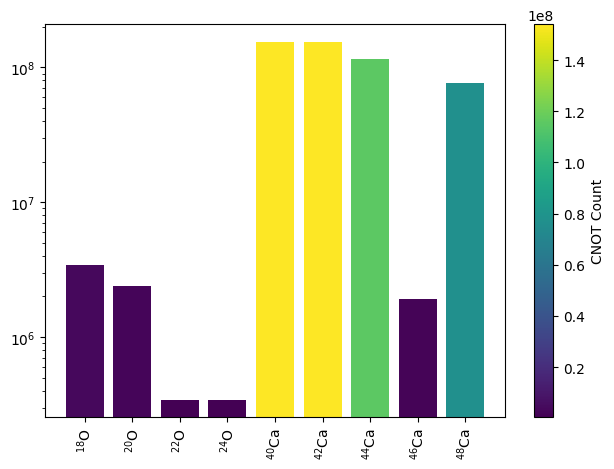

In [33]:


import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

# Example input
labels = titles_sd + titles_pf
values = cnot_sd + cnots_pf

# Create a colormap
norm = colors.Normalize(vmin=np.min(values), vmax=np.max(values))
cmap = cm.viridis  # Or any other colormap

# Assign colors based on value
bar_colors = cmap(norm(values))

# Plot bars with color
fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=bar_colors)
ax.set_xticklabels(labels, rotation=90)
plt.semilogy()
# Create and add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('CNOT Count')  # Optional: label the colorbar

plt.tight_layout()
plt.show()

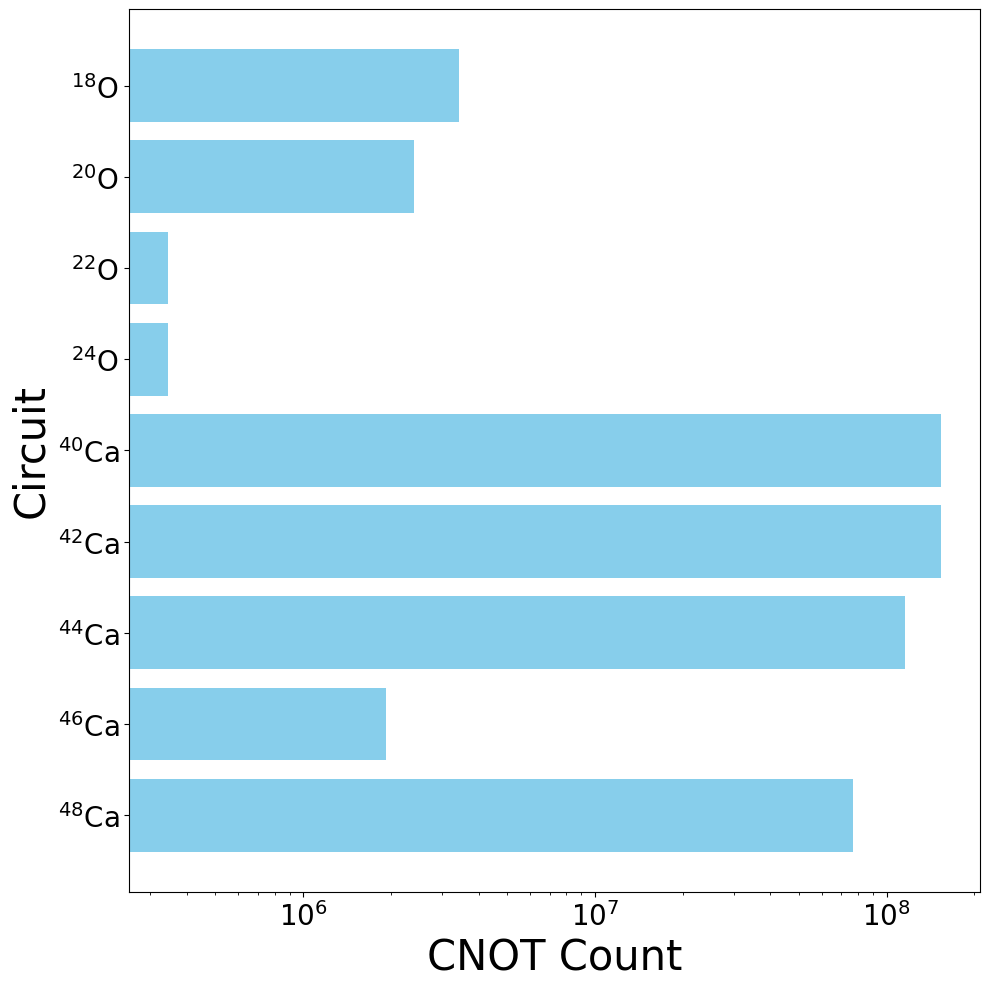

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Concatenate labels and values
labels = titles_sd + titles_pf
values = cnot_sd + cnots_pf

# Plot horizontal bars (default color)
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(labels, values, color='skyblue')  # optional: choose a single color

# Optional: put the highest value at the top
ax.invert_yaxis()

# Label axes
ax.set_xlabel("CNOT Count",fontsize=30)
ax.set_ylabel("Circuit",fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.semilogx()
plt.tight_layout()
plt.show()